In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-15 14:21:49.001696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 14:21:49.439888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 5
NB_LABEL_FEATURES = 1
WINDOW_WIDTH=5
SHUFFLE=True
MAX_EPOCHS = 3000
BATCH_SIZE=64
PATIENCE=50

In [3]:
N=1
T=1000
L = 1.5*128

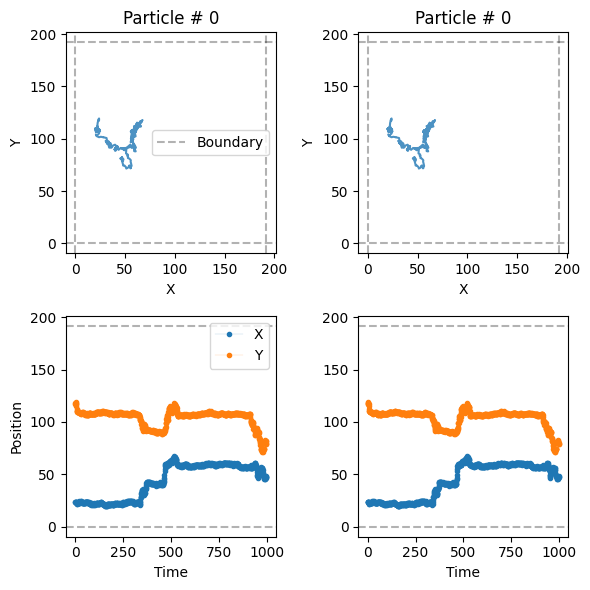

In [4]:
trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.5, 1.5],  # Fixed alpha for each state
                                                        Ds=[[0.1, 0.0], [1.0, 0.0]],# Mean and variance of each state
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
plot_trajs(trajs_model, L, N, num_to_plot =2)

In [5]:
changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(f'change points: {changepoints}, {changepoints.shape}')
print(f'alphas: {alphas}, {alphas.shape}')
print(f'Ds: {Ds}, {Ds.shape}')
print(f'State_nums: {state_num}, {state_num.shape}')

weight_for_0 = (1 / (T-len(changepoints))) * (T / 2.0)
weight_for_1 = (1 / len(changepoints) * (T / 2.0))
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(CLASS_WEIGHT)

change points: [  11  335  373  461  535  851  853  913 1000], (9,)
alphas: [1.5 0.5 1.5 0.5 1.5 0.5 1.5 0.5 1.5], (9,)
Ds: [1.  0.1 1.  0.1 1.  0.1 1.  0.1 1. ], (9,)
State_nums: [2. 2. 2. 2. 2. 2. 2. 2. 2.], (9,)
{0: 0.5045408678102926, 1: 55.55555555555555}


In [6]:
xs = trajs_model[:, 0, 0]
ys = trajs_model[:, 0, 1]
pos = np.array([xs, ys]).T
trajectory_object = TrajectoryObj(index=0)
for t, (x, y) in enumerate(pos):
    trajectory_object.add_trajectory_position(t, x, y, 0.0)
label_list = read_andi2_trajectory_label([Ds, alphas, state_num, changepoints])
trajectory_label = label_list[0]

In [7]:
"""
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')
trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
"""

"\ntrajectory_list = read_trajectory(f'data/trajs_fov_0.csv')\nlabel_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')\ntrajectory_object = trajectory_list[0]\ntrajectory_label = label_list[0]\n"

In [8]:
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3].astype(int)

In [9]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape, labeled_diff_coefs.shape, labeled_alphas.shape, labeled_states.shape, labeled_cps.shape)

(1000,) (1000,) (1000,) (1000,) (1000,) (1000,) (1000,) (1000,) (1000,)


In [10]:
df = np.array([xs, ys, msd, diff_coefs, angles]).T
df = pd.DataFrame(df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_cps]).T  # labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps
target_df = pd.DataFrame(target_df, columns=['cps'])  # 'lb_diff_coefs', 'alphas', 'states', 'cps'

In [11]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

target_train_df = target_df[0:int(n*0.7)]
target_val_df = target_df[int(n*0.7):int(n*0.9)]
target_test_df = target_df[int(n*0.9):]

In [12]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())
"""

"\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\nfor normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:\n    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n\ndf_std = (df - train_mean) / train_std\ndf_std = df_std.melt(var_name='Column', value_name='Normalized')\nplt.figure(figsize=(12, 6))\nax = sns.violinplot(x='Column', y='Normalized', data=df_std)\n_ = ax.set_xticklabels(df.keys(), rotation=90)\n\nprint(train_df.head())\n"

In [13]:
class WindowGenerator():
  def __init__(self, input_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               target_train_df=target_train_df, target_val_df=target_val_df,
               target_test_df=target_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = np.array(train_df).reshape(train_df.shape[0], NB_INPUT_FEATURES)
    self.val_df = np.array(val_df).reshape(val_df.shape[0], NB_INPUT_FEATURES)
    self.test_df = np.array(test_df).reshape(test_df.shape[0], NB_INPUT_FEATURES)

    self.target_train_df = np.zeros((train_df.shape[0] + int(input_width//2), NB_LABEL_FEATURES))
    self.target_val_df = np.zeros((val_df.shape[0] + int(input_width//2), NB_LABEL_FEATURES))
    self.target_test_df = np.zeros((test_df.shape[0] + int(input_width//2), NB_LABEL_FEATURES))

    self.target_train_df[int(input_width//2):] = target_train_df
    self.target_val_df[int(input_width//2):] = target_val_df
    self.target_test_df[int(input_width//2):] = target_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_indices = self.input_indices[0:1] + int(input_width//2)

    print('input_indices: ', self.input_indices)
    print('label_indices: ', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
def split_window(self, *args):
  inputs = args[0][:, self.input_slice, :]
  labels = args[1][:,:]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [16]:
def make_dataset(self, data, targets):
    data = np.array(data, dtype=np.float32)
    targets = np.array(targets, dtype=np.int8)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        sampling_rate=1,
        shuffle=SHUFFLE,
        batch_size=BATCH_SIZE,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df, self.target_train_df)

@property
def val(self):
  return self.make_dataset(self.val_df, self.target_val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, self.target_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
def compile_and_fit(model, window, patience=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                      patience=patience,
                                                      mode='min')
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=[tf.keras.metrics.BinaryAccuracy()]) 
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping])
    return history

In [19]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [20]:
wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print(f'Labels shape (batch, time, features): {example_labels[:5]}')

input_indices:  [0 1 2 3 4]
label_indices:  [2]


2024-03-15 14:22:05.891820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 14:22:05.897477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 14:22:05.897527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 14:22:05.900899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 14:22:05.900951: I tensorflow/compile

Inputs shape (batch, time, features): (64, 5, 5)
Labels shape (batch, time, features): (64, 1)
Labels shape (batch, time, features): [[0]
 [0]
 [0]
 [0]
 [0]]


In [21]:
wide_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [2]
Label column name(s): None

In [ ]:
%%time
residual_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), padding='same'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Dense(512),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

Epoch 1/3000


2024-03-15 14:22:14.767961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2024-03-15 14:22:14.776522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-15 14:22:14.776970: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559cbaac4a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 14:22:14.776990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-15 14:22:14.780481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03

11/11 [==============================] - 2s 43ms/step - loss: 0.6024 - binary_accuracy: 0.9626 - val_loss: 0.5983 - val_binary_accuracy: 0.9897
Epoch 2/3000
11/11 [==============================] - 0s 11ms/step - loss: 0.6022 - binary_accuracy: 0.9655 - val_loss: 0.5973 - val_binary_accuracy: 0.9897
Epoch 3/3000
11/11 [==============================] - 0s 12ms/step - loss: 0.6020 - binary_accuracy: 0.9655 - val_loss: 0.5971 - val_binary_accuracy: 0.9897
Epoch 4/3000
11/11 [==============================] - 0s 15ms/step - loss: 0.6019 - binary_accuracy: 0.9640 - val_loss: 0.5971 - val_binary_accuracy: 0.9897
Epoch 5/3000
11/11 [==============================] - 0s 11ms/step - loss: 0.6019 - binary_accuracy: 0.9640 - val_loss: 0.5969 - val_binary_accuracy: 0.9897
Epoch 6/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.6018 - binary_accuracy: 0.9640 - val_loss: 0.5962 - val_binary_accuracy: 0.9897
Epoch 7/3000
11/11 [==============================] - 0s 9ms/step - loss

In [56]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
#performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

<_MapDataset element_spec=(TensorSpec(shape=(None, 15, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int8, name=None))>
3/3 [==============================] - 0s 5ms/step - loss: 1.3008 - binary_accuracy: 0.4162



In [57]:
def make_prediction_set(test_set, window_width):
  pred_set = []
  for i in range(len(test_set)):
    tmp = test_set[i:i+window_width]
    if len(tmp) == window_width:
      pred_set.append(tmp)
  return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES, 1)


In [58]:
train_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_ = make_prediction_set(test_df, WINDOW_WIDTH)

train_result = residual_lstm.predict(train_)
test_result = residual_lstm.predict(test_)

print(target_train_df.shape)
print(test_df.shape)
print(train_result.shape, train_result[:10])
print(test_result.shape)

3/3 [==============================] - 0s 3ms/step
(700, 1)
(100, 5)
(686, 1) [[0.00071701]
 [0.00038837]
 [0.00031909]
 [0.00026192]
 [0.0002289 ]
 [0.00022221]
 [0.00020843]
 [0.00022054]
 [0.00021668]
 [0.00022116]]
(86, 1)


[ 252  328  347  352  500  538  625  710  758  829 1000]


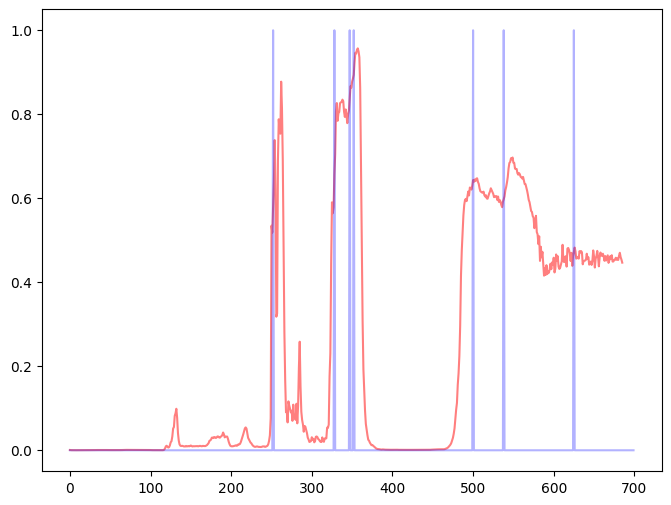

In [59]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(train_result[:,0]) >=1)
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red', alpha=0.5)
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['cps'], c='blue', alpha=0.3)

[ 252  328  347  352  500  538  625  710  758  829 1000]


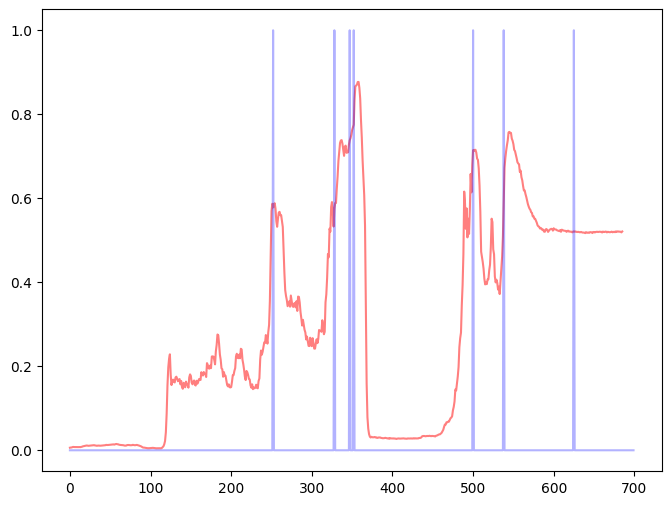

In [44]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red', alpha=0.5)
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['cps'], c='blue', alpha=0.3)

KeyError: 'lb_diff_coefs'

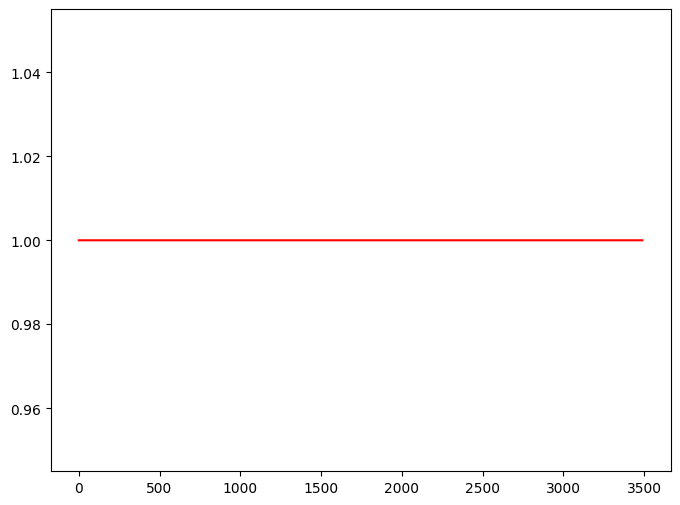

In [26]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [25]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

6/6 [==============================] - 1s 151ms/step


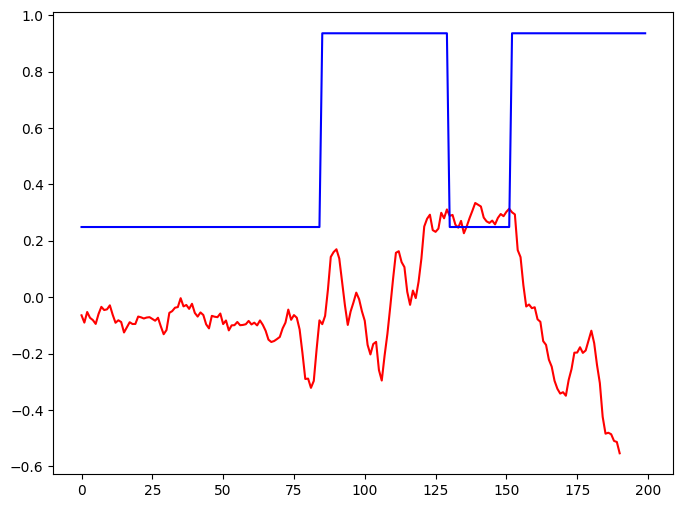

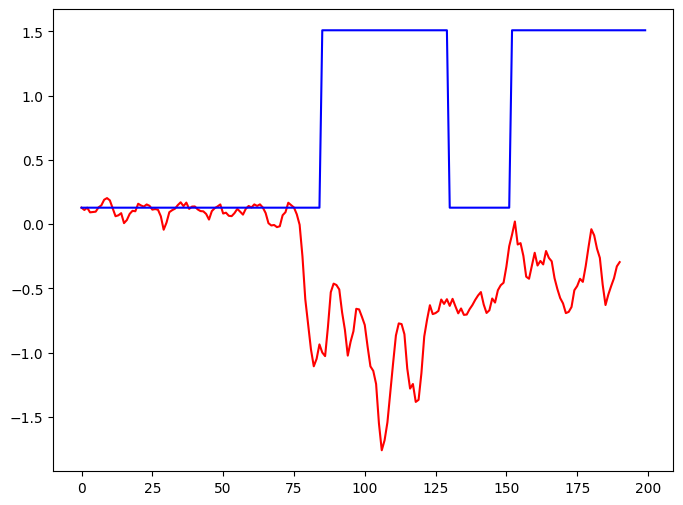

In [26]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')